In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt

In [2]:
img_root = './HDR-master/test_image/1'
img_names = ['DSC_0765.JPG', 'DSC_0766.JPG', 'DSC_0767.JPG', \
             'DSC_0768.JPG', 'DSC_0769.JPG', 'DSC_0770.JPG', \
             'DSC_0771.JPG', 'DSC_0772.JPG', 'DSC_0773.JPG', \
             'DSC_0774.JPG']

N = 50
l = 10

In [3]:
def getExif(img_path, tag):
    img = Image.open(img_path)
    exifdata = img.getexif()
    for tag_id in exifdata:
        tag_name = TAGS.get(tag_id, tag_id)
        if tag_name == tag:
            data = exifdata.get(tag_id)
            if isinstance(data, bytes):
                data = data.decode()
            return data
    return None

In [4]:
src_imgs = []
for img_name in img_names:
    src_img = cv2.imread(os.path.join(img_root, img_name))
    src_imgs.append(src_img)

In [5]:
exposure_times = []
for img_name in img_names:
    exposure_time = getExif(os.path.join(img_root, img_name), "ExposureTime")
    exposure_times.append(float(exposure_time))

In [6]:
def gsolve(Z, B, l, w):
    n = 256
    N, P = Z.shape[:2]
    
    A = np.zeros([N*P+n+1, n+N])
    b = np.zeros([A.shape[0], 1])
    
    # include the data-fitting equations
    k = 0
    for i in range(N):
        for j in range(P):
            wij = w[Z[i, j]]
            A[k, Z[i, j]] = wij
            A[k, n+i] = -wij
            b[k, 0] = wij * B[j]
            k = k + 1
    
    # fix the curve by setting its middle value to 0
    A[k, 127] = 1
    k = k + 1
    
    # include the smoothness equations
    for i in range(n-2):
        A[k, i] = l * w[i+1]
        A[k, i+1] = -2 * l * w[i+1]
        A[k, i+2] = l * w[i+1]
        k = k + 1
    
    # solve the system using SVD
    x = np.linalg.lstsq(A, b)[0]
    g = x[:n]
    lE = x[n+1:]
    
    return g, lE

In [15]:
def genlE(Z, B, g, w):
    P, height, width = Z.shape
    Z = Z.reshape([P, -1])
    lE = np.zeros([height * width]);
    for i in range(Z.shape[1]):
        n, d = 0, 0
        for j in range(P):
            z = Z[j][i]
            n += w[z] * (g[z] - B[j])
            d += w[z]
        lE[i] = n / d if d > 0 else n
    lE = lE.reshape([height, width])
    return lE

In [8]:
height, width = src_imgs[0].shape[:2]
sample_index = np.random.randint(min(height, width), size=(N, 2))

In [9]:
Z = np.zeros([N, len(src_imgs), 3])
for i in range(N):
    for j in range(len(src_imgs)):
        Z[i][j] = src_imgs[j][sample_index[i][0], sample_index[i][1]]
Z = Z.astype(int)

w = np.zeros([256])
for i in range(256):
    if i <= 127:
        w[i] = i
    else:
        w[i] = 255 - i

## Calculate R Channel

In [10]:
Z_r = Z[:, :, 2]
g_r, _ = gsolve(Z_r, np.log(exposure_times), l, w)

c:\users\yiting\anaconda3\envs\3dcv\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


## Calculate G Channel

In [11]:
Z_g = Z[:, :, 1]
g_g, _ = gsolve(Z_g, np.log(exposure_times), l, w)

c:\users\yiting\anaconda3\envs\3dcv\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


## Calculate B Channel

In [12]:
Z_b = Z[:, :, 0]
g_b, _ = gsolve(Z_b, np.log(exposure_times), l, w)

c:\users\yiting\anaconda3\envs\3dcv\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


## Plot Curves

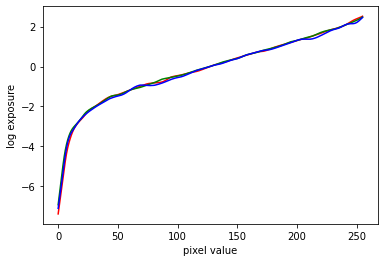

In [13]:
x_axis = [i for i in range(0, 256)]
plt.figure()
plt.plot(x_axis, g_r, label='r channel', color='r')
plt.plot(x_axis, g_g, label='g channel', color='g')
plt.plot(x_axis, g_b, label='b channel', color='b')
plt.xlabel('pixel value')
plt.ylabel('log exposure')
plt.show()

## Generate HDR Image

In [16]:
imgs = np.array(src_imgs)
Z_r = imgs[:, :, :, 2]
lE_r = genlE(Z_r.copy(), np.log(exposure_times), g_r, w)

In [17]:
Z_g = imgs[:, :, :, 1]
lE_g = genlE(Z_g.copy(), np.log(exposure_times), g_g, w)

In [40]:
Z_b = imgs[:, :, :, 0]
lE_b = genlE(Z_b.copy(), np.log(exposure_times), g_b, w)

In [45]:
E = np.zeros([height, width, 3])
E[:, :, 0] = lE_b
E[:, :, 1] = lE_g
E[:, :, 2] = lE_r
E = np.exp(E)

19308.291458140833


In [47]:
cv2.imwrite('./output/1.hdr', E)

True

## Test HDR

In [48]:
hdr = cv2.imread('./HDR-master/test_image/1/result/result.hdr', flags = cv2.IMREAD_ANYDEPTH)
print(np.max(hdr), np.min(hdr))

hdr1 = cv2.imread('./output/1.hdr', flags = cv2.IMREAD_ANYDEPTH)
print(np.max(hdr1), np.min(hdr1))
cv2.imshow('hdr', hdr1)
cv2.waitKey(0)

41216.0 0.0
1.0 0.0


-1